In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

img_wh = (400, 400)

In [33]:
# Change to your settings...
############################
encode_appearance = False
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.1
ckpt_path = 'ckpts/lego_nerfU_people_nonIID/epoch=8.ckpt'

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(9, 10)
embedding_dir = PosEmbedding(3, 4)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(100, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(100, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse').cuda()
nerf_fine = NeRF('fine',
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [34]:
@torch.no_grad()
def f(rays, ts):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

# Test on (perturbed) train images

In [35]:
perturbation = [] # ['occ']

dataset = dataset_dict['blender'] \
          ('/home/zt16/code/priv-nerf/nerfw_pl_priv/data/lego/res800_360view_IID_vertical_random',
           split='test_train',
           perturbation=perturbation,
           img_wh=img_wh,random_occ=False,yaw_threshold=50.0)

In [36]:
# sample an image ...
# 0 is unperturbed, others are perturbed
sample = dataset[88]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

/tmp/ipykernel_1398856/4193047959.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


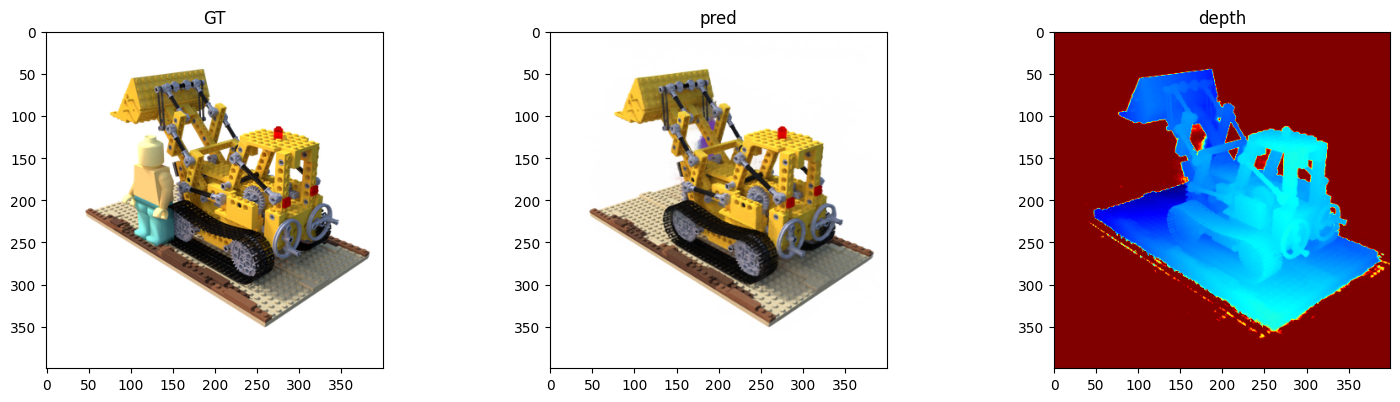

PSNR between GT and pred: 23.248193740844727 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/tmp/ipykernel_1398856/4193047959.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(241)


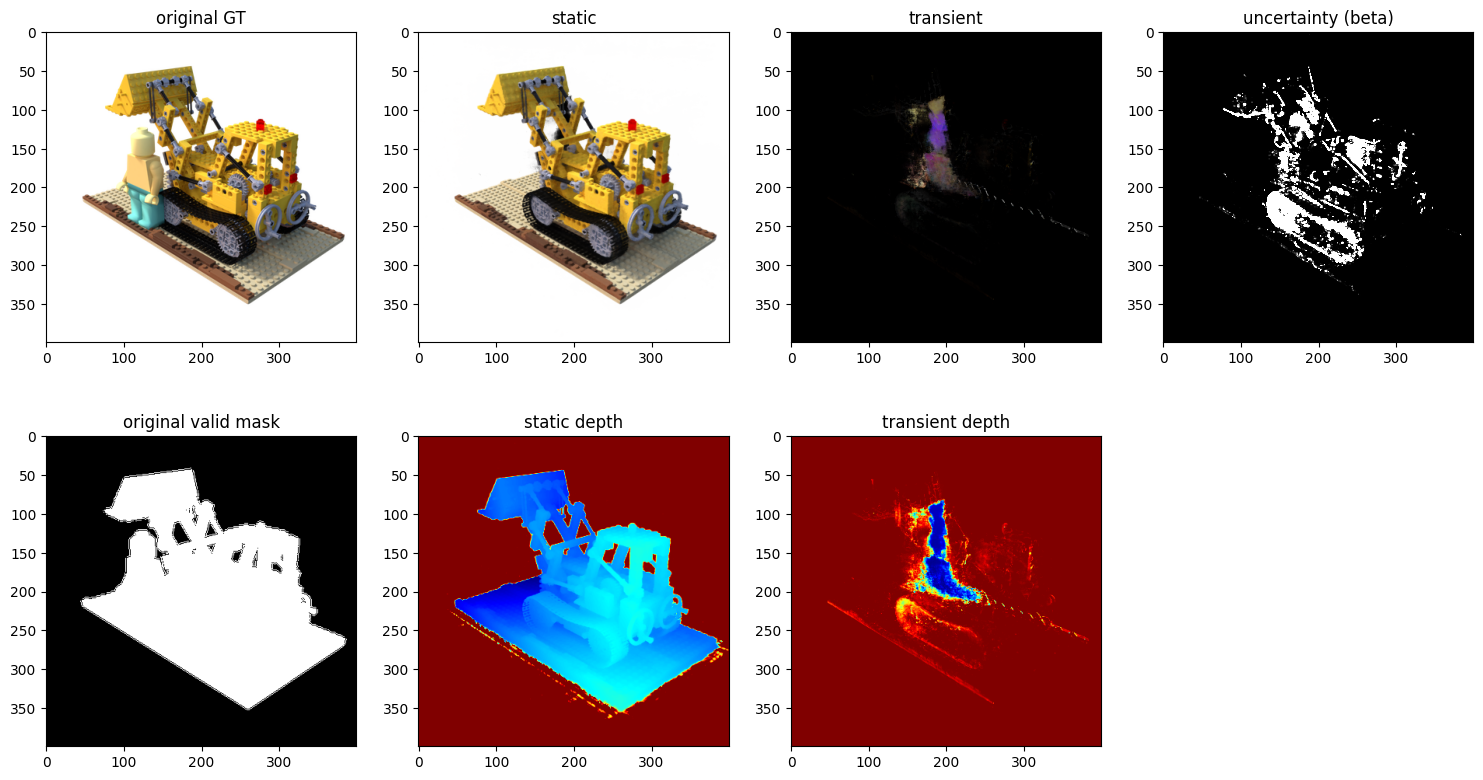

PSNR between original GT and static: 22.34964370727539


In [37]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['original_rgbs'].view(img_wh[1], img_wh[0], 3)
    valid_mask_static = sample['original_valid_mask'].view(img_wh[1], img_wh[0])
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()
    
    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())

In [9]:
results.keys()

dict_keys(['weights_coarse', 'opacity_coarse', 'weights_fine', 'opacity_fine', 'transient_sigmas', 'beta', '_rgb_fine_static', '_rgb_fine_transient', 'rgb_fine', 'rgb_fine_static', 'depth_fine_static', 'rgb_fine_transient', 'depth_fine_transient', 'depth_fine'])

# Test on 63th val image (same as the image in the paper Fig 13)

In [38]:
perturbation = []# ['occ']

valdataset = dataset_dict['blender'] \
          ('/home/zt16/code/priv-nerf/nerfw_pl_priv/data/lego/res800_360view_IID_vertical_random',
           split='val',
           perturbation=perturbation,
           img_wh=img_wh)

In [39]:
sample = valdataset[1]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

/tmp/ipykernel_1398856/2590934672.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


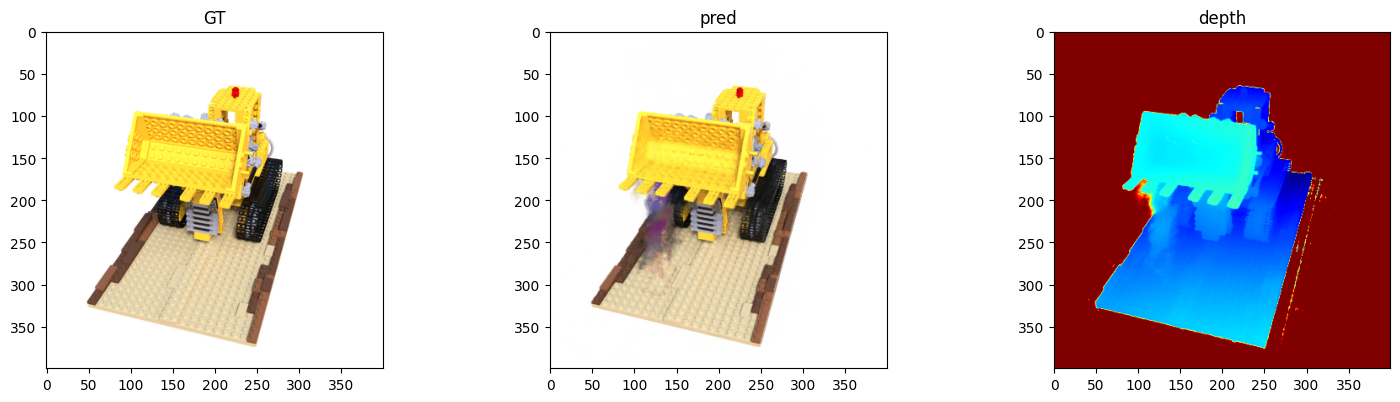

PSNR between GT and pred: 25.949932098388672 



In [40]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')

/tmp/ipykernel_1398856/1511521748.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(241)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


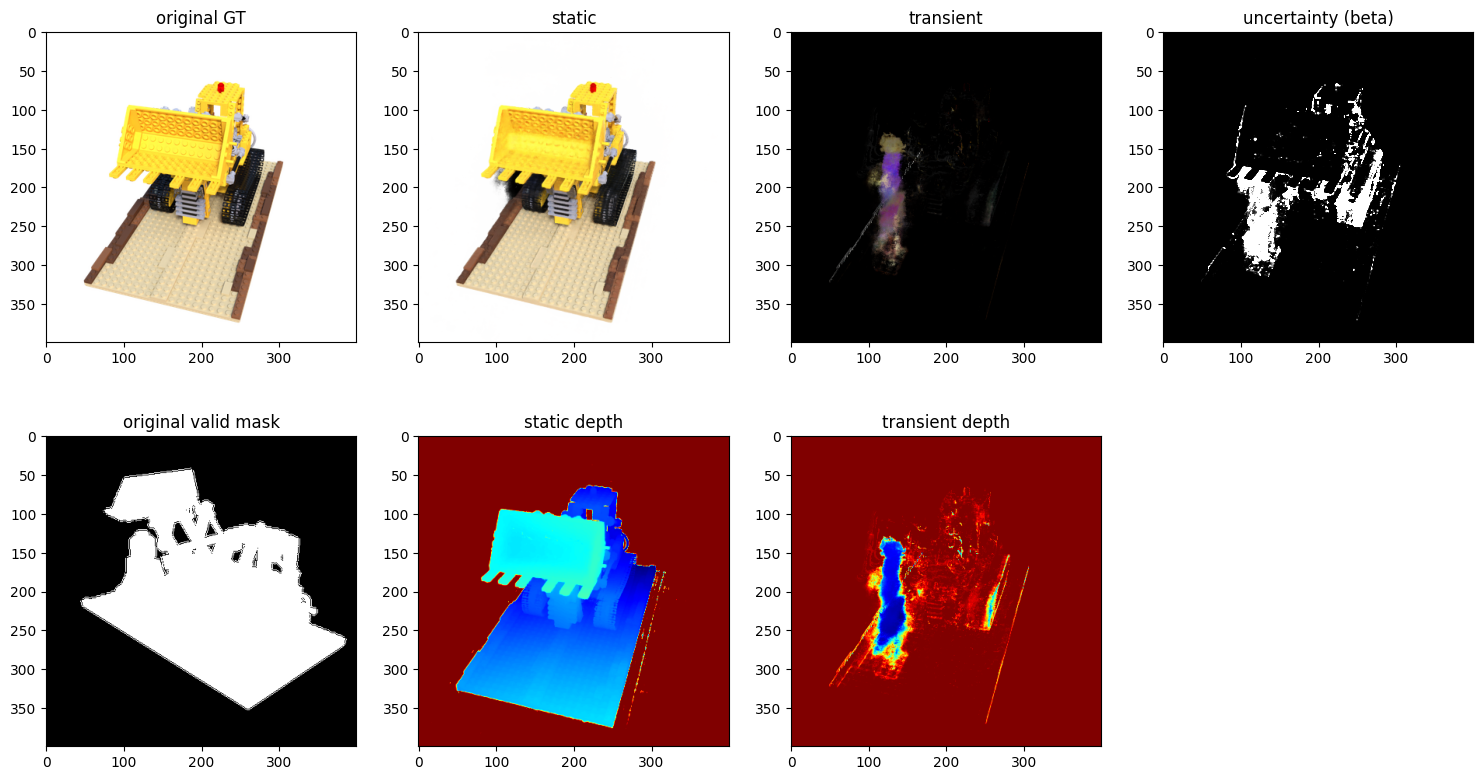

PSNR between original GT and static: 25.005586624145508


In [41]:
if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()
    
    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())